<div style="background-color: #009fd9; border-radius:0.25rem; padding-top:0.75rem; padding-bottom:1rem;">
  <h1 style="text-align:center;"> Providers Clustering </h1>
</div>

## Import the Required Libraries

In [63]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

## Load the Dataset

In [64]:
df = pd.read_excel('data/wallet_charges.xlsx', parse_dates=['wallet_charged_date'])

df.head()

,provider_user_id,wallet_charged_date,wallet_charged_amount
0,550102,2024-11-26 01:34:12,5000000
1,2019793,2024-11-26 01:04:23,2000000
2,430227,2024-11-26 01:35:09,2000000
3,739799,2024-11-26 00:47:09,2000000
4,2093162,2024-11-26 03:11:53,1600000


## Data Preprocessing

### Analyzing the First Month's Data

Analyzing the data of the first month to decide whether to include it in the analysis or discard it.

In [65]:
first_date = df["wallet_charged_date"].min().normalize()
first_day_of_first_month = first_date.replace(day=1)
exists_first_or_second_day = (
    df["wallet_charged_date"]
    .dt.floor("D")
    .isin([first_day_of_first_month, first_day_of_first_month + pd.Timedelta(days=1)])
).any()

if not exists_first_or_second_day:
    df = df[~(df["wallet_charged_date"].dt.month == first_date.month)]


### Analyzing the Last Month's Data

Analyzing the data of the last month to decide whether to include it in the analysis or discard it.

In [66]:
last_date = df["wallet_charged_date"].max().normalize()
last_day_of_last_month = last_date.replace(day=1) + pd.offsets.MonthEnd(0)
exists_last_day = (
    df["wallet_charged_date"]
    .dt.floor("D")
    .isin([last_day_of_last_month, last_day_of_last_month - pd.Timedelta(days=1)])
).any()

if not exists_last_day:
    df = df[~(df["wallet_charged_date"].dt.month == last_date.month)]

df.head()

,provider_user_id,wallet_charged_date,wallet_charged_amount
14961,2219963,2024-10-31 20:37:27,7000000
14962,1422472,2024-10-31 00:01:27,5000000
14963,386026,2024-10-31 19:40:58,5000000
14964,2154119,2024-10-31 16:41:21,5000000
14965,888178,2024-10-31 14:55:54,5000000


### Data Type Conversion

In [67]:
df['wallet_charged_amount'] = df['wallet_charged_amount'].astype('int32')
df['wallet_charged_date'] = df['wallet_charged_date'].dt.to_period('M')
df.rename(columns={'wallet_charged_date': 'wallet_charged_month'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79062 entries, 14961 to 94022
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   provider_user_id       79062 non-null  int64    
 1   wallet_charged_month   79062 non-null  period[M]
 2   wallet_charged_amount  79062 non-null  int32    
dtypes: int32(1), int64(1), period[M](1)
memory usage: 2.1 MB


### Monthly Data Abstraction

In [68]:
monthly_df = df.groupby(['provider_user_id', 'wallet_charged_month']).agg(
    monthly_total=('wallet_charged_amount', 'sum'),
    monthly_count=('wallet_charged_amount', 'count')
).reset_index()

monthly_df.head()

,provider_user_id,wallet_charged_month,monthly_total,monthly_count
0,256,2024-07,4000000,2
1,256,2024-08,2000000,1
2,256,2024-09,2000000,1
3,256,2024-10,4000000,2
4,394,2024-08,1000000,1


## Feature Engineering

### Feature Extraction

In [69]:
latest_month = monthly_df["wallet_charged_month"].max()

aggregated = monthly_df.groupby("provider_user_id").agg(
    latest_month_user=('wallet_charged_month', 'max'),
    total_active_months=('wallet_charged_month', 'count'),
    median_monthly_total=('monthly_total', 'median'),
    std_monthly_total=('monthly_total', 'std')
).reset_index()
aggregated['std_monthly_total'] = aggregated['std_monthly_total'].fillna(0)

aggregated['is_new'] = ((aggregated['total_active_months'] == 1) & (aggregated['latest_month_user'] == latest_month)).astype(int)
aggregated['is_active_now'] = (aggregated['latest_month_user'] == latest_month).astype(int)

providers = aggregated[['provider_user_id', 'median_monthly_total', 'std_monthly_total', 'total_active_months', 'is_new', 'is_active_now']]
features = providers[['median_monthly_total', 'std_monthly_total', 'total_active_months', 'is_new', 'is_active_now']]

providers.head()


,provider_user_id,median_monthly_total,std_monthly_total,total_active_months,is_new,is_active_now
0,256,3000000.0,1.154701e+06,4,0,1
1,394,1000000.0,0.000000e+00,1,0,0
2,415,500000.0,0.000000e+00,1,0,0
3,418,1500000.0,1.436431e+06,3,0,1
4,436,750000.0,3.535534e+05,2,0,1


### Feature Scaling

Scaling the features to ensure they are on the same scale for better clustering performance.

In [70]:
standard = StandardScaler()
scaled_features = standard.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

scaled_features_df.head()

,median_monthly_total,std_monthly_total,total_active_months,is_new,is_active_now
0,0.486179,0.437476,1.965926,-0.446222,1.045686
1,-0.274013,-0.381325,-0.768439,-0.446222,-0.956310
2,-0.464061,-0.381325,-0.768439,-0.446222,-0.956310
3,-0.083965,0.637252,1.054471,-0.446222,1.045686
4,-0.369037,-0.130620,0.143016,-0.446222,1.045686


## Clustering

### Determining the Number of Clusters (Using Elbow Method)

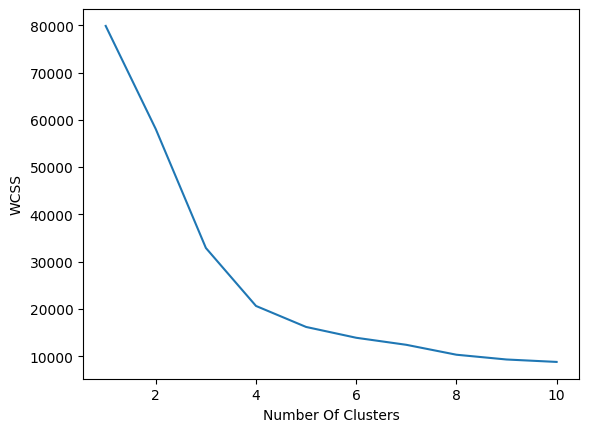

In [74]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(scaled_features_df)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number Of Clusters')
plt.ylabel('WCSS')
plt.show()

### Applying K-Means Clustering

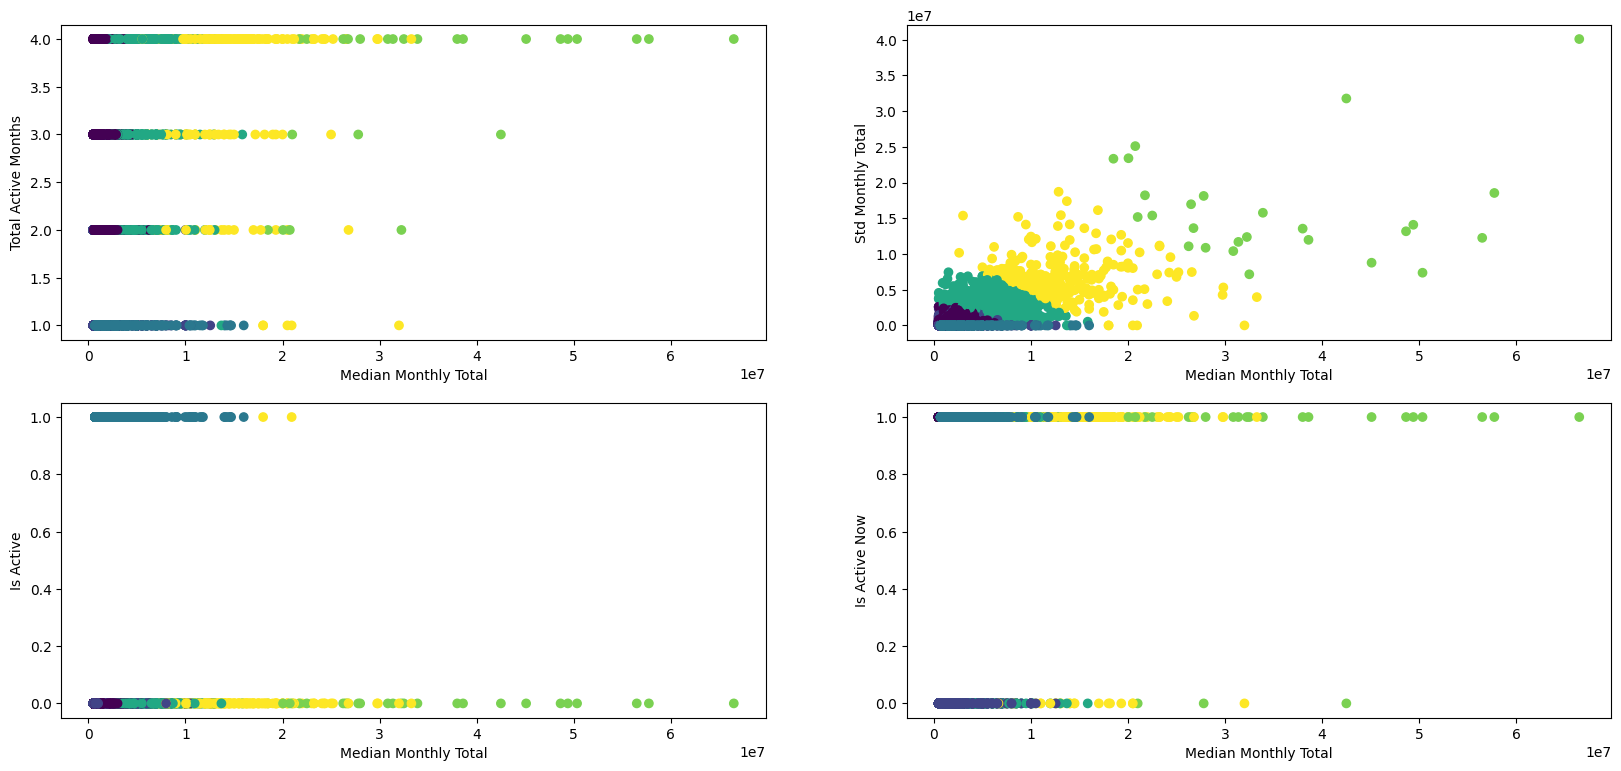

In [72]:
km = KMeans(n_clusters=6)
km.fit(scaled_features_df)
providers['cluster']=km.labels_


fig, axes = plt.subplots(2, 2, figsize=(20, 9))
axes[0, 0].scatter(providers['median_monthly_total'], providers['total_active_months'], c=providers['cluster']);
axes[0, 0].set_xlabel("Median Monthly Total");
axes[0, 0].set_ylabel("Total Active Months");
axes[0, 1].scatter(providers['median_monthly_total'], providers['std_monthly_total'], c=providers['cluster']);
axes[0, 1].set_xlabel("Median Monthly Total");
axes[0, 1].set_ylabel("Std Monthly Total");
axes[1, 0].scatter(providers['median_monthly_total'], providers['is_new'], c=providers['cluster']);
axes[1, 0].set_xlabel("Median Monthly Total");
axes[1, 0].set_ylabel("Is Active");
axes[1, 1].scatter(providers['median_monthly_total'], providers['is_active_now'], c=providers['cluster']);
axes[1, 1].set_xlabel("Median Monthly Total");
axes[1, 1].set_ylabel("Is Active Now");

# providers.head(20)

### Visualization of Clusters

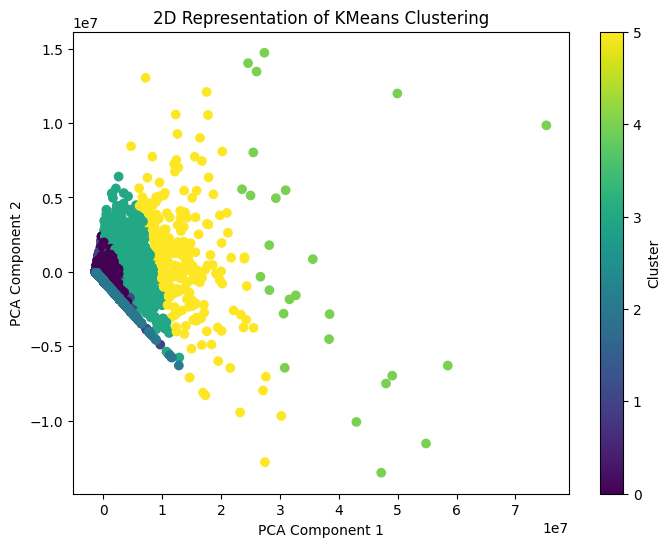

In [73]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=providers['cluster'], cmap='viridis', marker='o')
plt.title('2D Representation of KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
